In [1]:
import gymnasium as gym
import os
import sys
import numpy as np
sys.path.append("./jsbgym")
import jsbgym
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.vec_env import SubprocVecEnv
import matplotlib.pyplot as plt

# Task setup

### Altitude

In [2]:
env = gym.make("A320-AltitudeHoldTask-Shaping.STANDARD-NoFG-v0", render_mode="human")

CHECKPOINT_DIR = "./train/engine_alt_hold/"
LOG_DIR = "./logs/engine_alt_hold/"

env.reset()
env.render()



     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



### Altitude rate

In [ ]:
gamma = 0.99

env = gym.make("A320-HdotHoldTask-Shaping.STANDARD-NoFG-v0", render_mode=None, gamma=gamma)

CHECKPOINT_DIR = "./train/engine_hdot_hold/"
LOG_DIR = "./logs/engine_hdot_hold/"

env.reset()
env.render()



     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



/home/pietbcm/diff_thrust_rl/jsbgym/jsbgym/environment.py:156: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("A320-HdotHoldTask-Shaping.STANDARD-NoFG-v0", render_mode="human")
  gym.logger.warn(


### Heading and altitude rate

In [2]:
gamma = 0.995

env = gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode=None, gamma=gamma)

CHECKPOINT_DIR = "./train/engine_phi_hdot/"
LOG_DIR = "./logs/engine_phi_hdot/"

env.reset()
env.render()



     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



/home/pietbcm/diff_thrust_rl/jsbgym/jsbgym/environment.py:156: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode="human")
  gym.logger.warn(


### Parallel simulation

In [ ]:
# Attempt at parallel simulation, didn't work because of JSBSim
def make_env():
    def _init():
        env = gym.make("A320-HdotHoldTask-Shaping.STANDARD-NoFG-v0", render_mode=None, gamma=gamma)
        # env.reset()
        return env
    return _init

n_envs = 4
env = SubprocVecEnv([make_env() for _ in range(n_envs)])

In [3]:
# Test the environment with random inputs

for episode in range(1, 6):
    obs, info = env.reset()
    done = False
    total_reward = 0
    while not done:
        # action = np.array([1, 0], dtype=np.float32)
        action = env.action_space.sample()
        obs, reward, done, _, info = env.step(action)
        
        total_reward += reward
    print("Total Reward for episode {} is {}".format(episode, total_reward))

Total Reward for episode 1 is -4.2004386438049135
Total Reward for episode 2 is -2.9157849949610997
Total Reward for episode 3 is -7.926890703613528
Total Reward for episode 4 is -2.9622564082346097
Total Reward for episode 5 is -4.176468362961436


# Training

In [4]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(
                self.save_path, "best_model_{}".format(self.n_calls)
            )
            self.model.save(model_path)

        for info in self.locals["infos"]:
            if "episode" in info.keys():
                for log_var, value in info["episode"].items():
                    if log_var in ["r", "l", "t"]: continue
                    self.logger.record(f"episode/{log_var}", value)
                    
        return True
    
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [5]:
# Create new PPO model

model = PPO("MlpPolicy", env, tensorboard_log=LOG_DIR, device="cpu", gamma=gamma)

# model = PPO("MlpPolicy", env, tensorboard_log=LOG_DIR, device="cpu", 
#             policy_kwargs=dict(net_arch=dict(pi=[128, 128, 64], vf=[128, 128, 64])),
#             gamma=gamma)

In [ ]:
# Continue from an old model. Used for curriculum learning

old_model = PPO.load("train/saved_models/hdot_phi_20_1_N_2000000.zip", device="cpu")
# old_model = PPO.load("train/saved_models/hdot_phi_20_3_N_2000000.zip", device="cpu")
# old_model = PPO.load("final_model", device="cpu")

model = PPO("MlpPolicy", env, tensorboard_log=LOG_DIR, device="cpu", gamma=gamma)
model.policy.load_state_dict(old_model.policy.state_dict())

# model = old_model

<All keys matched successfully>

In [6]:
# Training loop
model.learn(total_timesteps=2000000, callback=callback)
model.save("final_model")

## Evaluation and visualization

In [8]:
env = gym.make("A320-AltitudeHoldTask-Shaping.STANDARD-FG-v0", render_mode="human_fg")
env.reset()
model = PPO.load("final_model.zip", device="cpu")



     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



/home/pietbcm/diff_thrust_rl/jsbgym/jsbgym/environment.py:140: UserWarning: If training, use NoFG instead of FG in the env_id. Using FG will cause errors while training after a while.
  warnings.warn(


In [9]:
env = gym.make("A320-HdotHoldTask-Shaping.STANDARD-FG-v0", render_mode="human_fg")
env.reset()
# model = PPO.load(os.path.join("train/engine_hdot_hold", "best_model_100000"), device="cpu")
model = PPO.load("final_model.zip", device="cpu")



     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



In [15]:
# env = gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-FG-v0", render_mode="human_fg")
env = gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode=None)
# env = gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode="human")
# env = gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode="graph")
env.reset()

# model = PPO.load(os.path.join("train/engine_psidot_hdot", "best_model_1300000"), device="cpu")
# model = PPO.load(os.path.join("train/engine_psidot_hdot", "best_model_1800000"), device="cpu")
# model = PPO.load(os.path.join("train/engine_psidot_hdot", "best_model_1000000"), device="cpu")
# model = PPO.load(os.path.join("train/engine_psidot_hdot", "best_model_1000000"), device="cpu")
model = PPO.load("final_model.zip", device="cpu")
# model = PPO.load(os.path.join("train/saved_models", "hdot_phi_20_3_N_2000000"))




     JSBSim Flight Dynamics Model v1.2.3 Jun  7 2025 19:28:34
            [JSBSim-ML v2.0]

JSBSim startup beginning ...



In [11]:
env.render()

/home/pietbcm/diff_thrust_rl/jsbgym/jsbgym/environment.py:156: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("A320-HeadingAndAltitudeRateTask-Shaping.STANDARD-NoFG-v0", render_mode="human")
  gym.logger.warn(


In [12]:
for episode in range(1, 6):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        total_reward += reward

    print("Total Reward for episode {} is {}".format(episode, total_reward))

Total Reward for episode 1 is -0.9261685950545788
Total Reward for episode 2 is -2.2313138062296547
Total Reward for episode 3 is -3.1519437919312963
Total Reward for episode 4 is -1.2870111229906824
Total Reward for episode 5 is -1.030692759692215


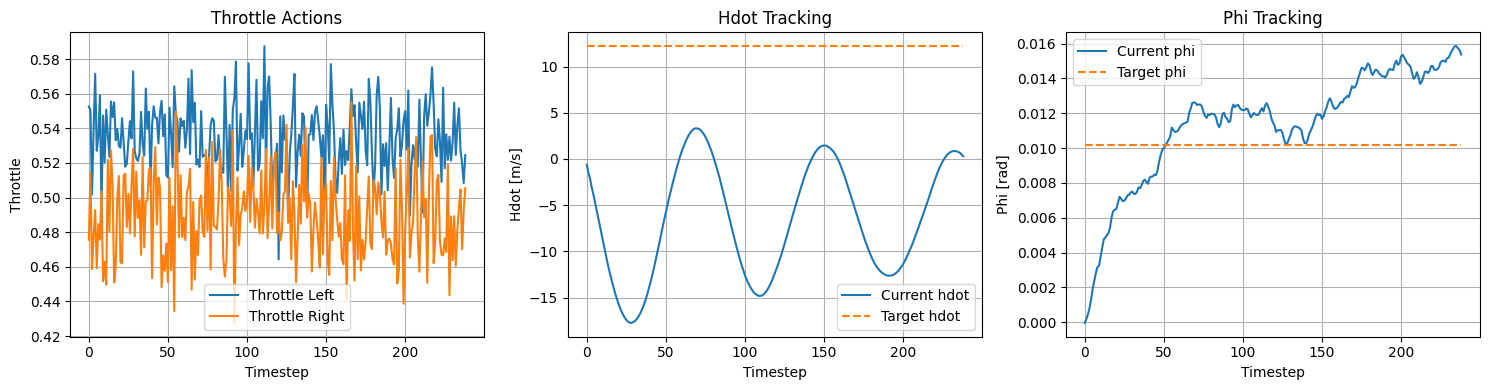

In [13]:
# Plot 1 episode
action_list = np.empty((0, 2))
hdot_error_list = np.array([])
phi_error_list = np.array([])
curr_hdot_list = np.array([])
curr_phi_list = np.array([])
target_hdot_list = np.array([])
target_phi_list = np.array([])

obs, _ = env.reset()
done = False

while not done:
    action, _ = model.predict(obs)
    obs, reward, done, _, info = env.step(action)

    action_list = np.vstack([action_list, action])
    hdot_error_list = np.append(hdot_error_list, obs[9])
    phi_error_list = np.append(phi_error_list, obs[10])
    curr_hdot_list = np.append(curr_hdot_list, info["curr_hdot"])
    curr_phi_list = np.append(curr_phi_list, info["curr_phi"])
    target_hdot_list = np.append(target_hdot_list, info["target_hdot"])
    target_phi_list = np.append(target_phi_list, info["target_phi"])

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(action_list[:, 0], label="Throttle Left")
axs[0].plot(action_list[:, 1], label="Throttle Right")
axs[0].set_title("Throttle Actions")
axs[0].set_xlabel("Timestep")
axs[0].set_ylabel("Throttle")
axs[0].legend()
axs[0].grid()

axs[1].plot(curr_hdot_list, label="Current hdot")
axs[1].plot(target_hdot_list, label="Target hdot", linestyle="--")
axs[1].set_title("Hdot Tracking")
axs[1].set_xlabel("Timestep")
axs[1].set_ylabel("Hdot [m/s]")
axs[1].legend()
axs[1].grid()

axs[2].plot(curr_phi_list, label="Current phi")
axs[2].plot(target_phi_list, label="Target phi", linestyle="--")
axs[2].set_title("Phi Tracking")
axs[2].set_xlabel("Timestep")
axs[2].set_ylabel("Phi [rad]")
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

In [16]:
# Calculate RMSE over multiple episodes
all_curr_hdot = np.array([])
all_target_hdot = np.array([])
all_curr_phi = np.array([])
all_target_phi = np.array([])

num_episodes = 100

for ep in range(num_episodes):
    obs, _ = env.reset()
    done = False

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, _, info = env.step(action)

        all_curr_hdot = np.append(all_curr_hdot, info["curr_hdot"])
        all_target_hdot = np.append(all_target_hdot, info["target_hdot"])
        all_curr_phi = np.append(all_curr_phi, info["curr_phi"])
        all_target_phi = np.append(all_target_phi, info["target_phi"])

hdot_rmse = np.sqrt(np.mean((all_target_hdot - all_curr_hdot) ** 2))
phi_rmse = np.sqrt(np.mean((all_target_phi - all_curr_phi) ** 2))

print(f"Hdot RMSE over {num_episodes} episodes: {hdot_rmse:.4f}")
print(f"Phi RMSE over {num_episodes} episodes: {phi_rmse:.4f}")


Hdot RMSE over 100 episodes: 13.5245
Phi RMSE over 100 episodes: 0.0151


In [ ]:
env.close()